In [44]:
### Packages

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily as ctx
import osmnx as ox
import networkx as nx
import statistics
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib as mpl
import random


In [ ]:
### Set working directory

path=''
os.chdir(path)

In [ ]:
### Figure 1A - Barriers map

# Create folders if they don't exist
outdir= '.\\Figures'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
# function to create buffer around the barrier islands for better visualization in the map
def buffer(row):
     return row.geometry.buffer(3000)

barriers= gpd.read_file('.\\Data\\Exceedance\\US_barriers.shp')
barriers= barriers.to_crs('esri:102003')
barriers['geometry'] = barriers.apply(buffer, axis=1)

table = pd.read_csv(".\\Results\\Results_AllBarriers.csv", sep=",", header=0) 
developed_barriers= list(table.Barrier)

def color(row):
    if row['name'] in developed_barriers:
        val = "#00A9E6"
    else:
        val = "#004C73"
    return val

barriers['Color'] = barriers.apply(color, axis=1)

# Create map with OSM as basemap
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(15*cm,15*cm))

barriers = barriers.to_crs(epsg=3857)

barriers.plot(ax=ax, color=barriers.Color, linewidth=2, legend=True)
minx, miny, maxx, maxy = barriers.total_bounds
ax.set_xlim(minx-100000, maxx+300000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax,zoom=5,source=ctx.providers.CartoDB.Positron, alpha=0.5, attribution="") # add basemap (OSM)
plt.xticks(fontsize=6) # reduce fontsize of x axis
plt.yticks(fontsize=6, rotation='vertical') # reduce fontsize of y axis
ax.ticklabel_format(style='plain')  

legend_elements = [Line2D([0], [0], color='#004C73', linewidth=3, label='< 100 nodes'),
                   Line2D([0], [0], color="#00A9E6", linewidth=3, label='> 100 nodes'),
                   ] # create legend
leg=ax.legend(handles=legend_elements, handlelength=1, loc='lower right', frameon=True, fontsize=7)
leg.set_title('barrier islands',prop={'size':8})
leg.get_frame().set_linewidth(0.2)

plt.savefig(".\\Figures\\Fig1a.png", dpi=500, facecolor='w', bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig1a.eps", dpi=500, facecolor='w', bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 1B - Map example network 

table = pd.read_csv(".\\Results\\Results_AllBarriers.csv", sep=",", header=0) 

# Read polygon and extract network
poly = gpd.read_file(".\\Data\\Barriers\\Barriers_AtlGulf\\NC21_geo.shp")
poly_geo = poly['geometry'].iloc[0]
poly_geo = poly_geo.buffer(0)
poly_geo.is_valid
graph = ox.graph_from_polygon(poly_geo, network_type='drive', simplify=True, clean_periphery=True)
nodes, edges = ox.graph_to_gdfs(graph)
nodes['index'] = range(0, len(nodes))

# Create map with OSM as basemap
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(15*cm,20*cm))

nodes = nodes.to_crs(epsg=3857) # convert to EPSG used by basemaps
edges = edges.to_crs(epsg=3857)
nodes.plot(ax=ax, facecolor="g", edgecolor='none',  markersize=3, zorder=2, legend=True) # plot nodes
edges.plot(ax=ax, color='#696969', linewidth=1, zorder=1) # plot edges
ctx.add_basemap(ax, zoom=15, source=ctx.providers.CartoDB.Positron, attribution="") # add basemap (OSM)
plt.xticks(fontsize=6) # reduce fontsize of x axis
plt.yticks(fontsize=6, rotation='vertical') # reduce fontsize of y axis
ax.ticklabel_format(style='plain') 
plt.locator_params(axis='y', nbins=4)

legend_elements = [Line2D([0], [0], marker='o', color='none', markeredgecolor='g', markerfacecolor='g', label='nodes/intersections', markersize=3),
                   Line2D([0], [0], color='#696969', label='edges/roads', linewidth=1)] # create legend
leg= ax.legend(handles=legend_elements, handlelength=1, loc='lower right', frameon=True, fontsize=8)
leg.get_frame().set_linewidth(0.2)

plt.savefig(".\\Figures\\Fig1b.png", dpi=500, transparent=True, bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig1b.eps", dpi=500, facecolor='w', bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 3a - Example identification of the critical node during node removal

# Explore size of the first and second GCC sizes during node removal
G = nx.read_graphml('.\\Data\\Roads\\NC21.graphml')
GCCs=[]
E = nx.get_node_attributes(G,'Elevations')
E = dict(zip(E.keys(), [float(value) for value in E.values()]))
Sorted_E = sorted(E.items(), key=lambda item: item[1])
CCs = np.zeros([len(Sorted_E),2])
FT = [i[0] for i in Sorted_E]
ST = [i[1] for i in Sorted_E]
for i in range(len(ST)):
    ST[i] = float(ST[i])
for i in range(0, len(FT)):
    G.remove_nodes_from(FT[0:i])
    GCC = [len(c)
            for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)
        ]
    GCCs.append(GCC) # list with the number of connected components and its size
    if len(GCC)==1:
        CCs[int(i),0]=GCC[0]/len(FT)
        CCs[int(i),1]=0
    else:
        CCs[int(i),0]=GCC[0]/len(FT)
        CCs[int(i),1]=GCC[1]/len(FT)

# Identify critical node network: when the first GCC has the highest decrease and the size of the second cluster reaches its maximum
m = max(CCs[:,1])
pos=[i for i, j in enumerate(CCs[:,1]) if j == m]
pos= pos[0] # position of max value in SGC
critical= pos-1 # position of the critical node 
elev=ST[critical] # find elevation of the critical node
removed=pos # number of nodes removed at the critical threshold

# Plot it up
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(6*cm,3*cm))

col1=[] 
for i in range(0,len(FT)):
    if i==critical:
        col1.append('#D53032') 
    else:
        col1.append('#000000')  
col2=[]
for i in range(0,len(FT)):
    if i==critical:
        col2.append('#D53032') 
    else:
        col2.append('#808080') 
col3=[]
for i in range(0,len(FT)):
    if i==critical:
        col3.append('#D53032') 
    else:
        col3.append('#9ACD32') 

x_coord = 1 * np.arange(len(FT))/len(FT) # fraction of nodes removed
ax.plot(x_coord, CCs[:,0],':ok', markersize=2)

for i in range (len(FT)):
    ax.plot(x_coord[i],CCs[i,0],'o', markersize=2, color=col1[i]) # FGC with two colors to highlight critical node
ax.set_ylabel("first GCC size", fontsize=6)
ax2 = ax.twinx()
ax2.plot(x_coord, CCs[:,1],':ok', markersize=2)
for i in range (len(FT)):
    ax2.plot(x_coord[i],CCs[i,1],'o', markersize=2, color=col2[i]) # SGC with two colors to highlight critical node
ax2.set_ylabel("second GCC size", fontsize=6)
ax.set_xlabel("q", fontsize=6)

legend_elements = [Line2D([0], [0], marker='o', color= 'none', markeredgecolor='#000000', markerfacecolor='#000000', label='first GCC', markersize=3),
                    Line2D([0], [0], marker='o', color='none', markeredgecolor='#808080', markerfacecolor='#808080', label='second GCC', markersize=3),
                    Line2D([0], [0], marker='o', color='none', markeredgecolor='#D53032', markerfacecolor='#D53032', label='critical node', markersize=3)]
ax.legend(handles=legend_elements, loc="best", frameon=False, fontsize=4)

ax.tick_params(axis='both', which='major', labelsize=6)
ax2.tick_params(axis='both', which='major', labelsize=6)

plt.rcParams["font.size"]= 6

plt.savefig(".\\Figures\\Fig3a.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig3a.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)


In [ ]:
### Figure 3b - Example critical node in physical network 

# Read polygons
poly = gpd.read_file(".\\Data\\Barriers\\Barriers_AtlGulf\\NC21_geo.shp")
poly_geo = poly['geometry'].iloc[0]
poly_geo = poly_geo.buffer(0)
poly_geo.is_valid
graph = ox.graph_from_polygon(poly_geo, network_type='drive', simplify=True, clean_periphery=True)
nodes, edges = ox.graph_to_gdfs(graph)
nodes['index'] = range(0, len(nodes))
G = nx.read_graphml('.\\Data\\Roads\\NC21.graphml')
E = nx.get_node_attributes(G,'Elevations')
E = dict(zip(E.keys(), [float(value) for value in E.values()]))
E = pd.DataFrame(list(E.items()),columns = ['index','elevation'])
E = E.apply(pd.to_numeric)
nodes = nodes.merge(E, on='index')


def color(row):
    if row['elevation'] < elev:
        val = "black"
    elif row['elevation']== elev:
        val = "red"
    else:
        val = "green"
    return val

nodes['Color'] = nodes.apply(color, axis=1) # new column with color categories 

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(7*cm,10*cm))
nodes = nodes.to_crs(epsg=3857) # convert to EPSG used by basemaps
edges = edges.to_crs(epsg=3857)
nodes.plot(ax=ax,  color=nodes.Color,  markersize=1, zorder=2, legend=True) # plot nodes
edges.plot(ax=ax, color='#696969', linewidth=0.5, zorder=1) # plot edges
ctx.add_basemap(ax, zoom=15, source=ctx.providers.CartoDB.Positron, attribution="") # add basemap (OSM)

plt.xticks(fontsize=5) # reduce fontsize of x axis
plt.yticks(fontsize=5, rotation='vertical') # reduce fontsize of y axis

ax.ticklabel_format(style='plain') 
legend_elements = [Line2D([0], [0], marker='o', color='none', label='connected',
                          markeredgecolor='g', markerfacecolor='g', markersize=3),
                   Line2D([0], [0], marker='o', color='none', label='disconnected',
                          markeredgecolor='k', markerfacecolor='k', markersize=3),
                   Line2D([0], [0], marker='o', color='none', label='critical node',
                          markeredgecolor='r', markerfacecolor='r', markersize=3),
                   ] # create legend
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=4)
      
plt.savefig(".\\Figures\\Fig3b.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig3b.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 3c- Example R 

G = nx.read_graphml('.\\Data\\Roads\\NC21.graphml')

# Pull out elevation attribute
E = nx.get_node_attributes(G,'Elevations')
# Convert str values in float to be able to sort them 
E = dict(zip(E.keys(), [float(value) for value in E.values()]))
# Sort it based on elevation, min first
Sorted_E = sorted(E.items(), key=lambda item: item[1])
CCs = np.zeros([len(Sorted_E),1])
# Select first element of each tuple in the list (nodes ID):
FT = [i[0] for i in Sorted_E]
# Select second element of each tuple in the list (elevation) and convert to float
ST = [i[1] for i in Sorted_E]
for i in range(len(ST)):
    ST[i] = float(ST[i])
# Loop through all nodes
for i in range(0, len(FT)):
    # find the node with lowest elevation from the list using i and remove it
    G.remove_nodes_from(FT[0:i])
    # check giant component size
    CCs[int(i),0]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT)
# Calculate robustness following Schneider's equation (2011) and include it in plot
s= sum(CCs[:,0])
r= s/len(FT)
r_norm= int(round(r/0.5*100))

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(4*cm,3*cm))
x = 1 * np.arange(len(CCs))/len(CCs) # x axis
y=CCs[:,0]
plt.axline((0, 1), (1, 0), linewidth=1, zorder=1, color='#999999', linestyle='--')
plt.plot(x,y,'-', color="g", label="GCC")
plt.fill_between(x,y, color="g", alpha=0.3, label='R')


plt.rcParams["font.size"]= 6      
plt.xlabel("q", fontsize=6)
plt.ylabel("GCC size", fontsize=6)

plt.legend(fontsize=4, frameon=False)

plt.savefig(".\\Figures\\Fig3c.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig3c.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)


In [ ]:
### Figure 4a - Histogram island area 

barriers= gpd.read_file('.\\Data\\Exceedance\\US_barriers.shp')
barriers= barriers.to_crs('esri:102003')
barriers["area"] = barriers['geometry'].area/ 10**6
barriers["length"]= barriers['geometry'].length/10**3


def find_bins(observations, width):
    minimmum = np.min(observations)
    maximmum = np.max(observations)
    bound_min = -1.0 * (minimmum % width - minimmum)
    bound_max = maximmum - maximmum % width + width
    n = int((bound_max - bound_min) / width) + 1
    bins = np.linspace(bound_min, bound_max, n)
    return bins       

table = pd.read_csv(".\\Results\\Stats.csv", sep=",", header=0) 
developed_barriers= list(table.Barrier)
developed = barriers.query('name in @developed_barriers')

bins = find_bins(developed['area'], 25)

cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(4*cm, 4*cm))

plt.hist(developed['area'], histtype='step',  color='k', linewidth=1,  bins=bins)
plt.xlabel("total area ($\mathregular{km^2}$)")
plt.ylabel("# barriers")


plt.xticks(fontsize=6) # reduce fontsize of x axis
plt.yticks(fontsize=6, rotation='vertical') # reduce fontsize of y axis

plt.rcParams["font.size"]= 6

plt.savefig(".\\Figures\\Fig4a.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig4a.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 4b- Histogram total road length 

rootdir = '.\\Results\Statistics'
extensions = ('.csv')

barrier_names=[]
length_street=[]

# Loop through files with statistics and open each csv 
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            file_path = os.path.join(subdir, file)
            barrier = file.replace(".csv","")
            barrier = file.replace("_geo","")
            barrier_names.append(barrier)
            table = pd.read_csv(file_path, sep=",", header=0)
            table.rename(columns={ table.columns[0]: "stats", table.columns[1]:"values"}, inplace = True)
            length=table.loc[table['stats'] == 'street_length_total', 'values'].iloc[0]/10**3
            length_street.append(length)

df = list(zip(barrier_names, length_street))
df = pd.DataFrame(df, columns=['Barrier','Street_length'])

table = pd.read_csv(".\\Results\\Results_AllBarriers.csv", sep=",", header=0) 
developed_barriers= list(table.Barrier)
developed = df.query('Barrier in @developed_barriers')

def find_bins(observations, width):
    minimmum = np.min(observations)
    maximmum = np.max(observations)
    bound_min = -1.0 * (minimmum % width - minimmum)
    bound_max = maximmum - maximmum % width + width
    n = int((bound_max - bound_min) / width) + 1
    bins = np.linspace(bound_min, bound_max, n)
    return bins


cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(4*cm, 4*cm))

plt.rcParams["font.size"]= 6

bins = find_bins(df['Street_length'], 50)
plt.hist(df['Street_length'], histtype='step', color='k', linewidth=1, bins=bins)

plt.xlabel("total road length (km)")
plt.ylabel("# barriers")

plt.xticks(fontsize=6) # reduce fontsize of x axis
plt.yticks(fontsize=6, rotation='vertical') # reduce fontsize of y axis

plt.savefig(".\\Figures\\Fig4b.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig4b.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

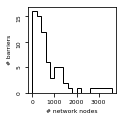

In [27]:
##### Figure 4c - Histogram number of nodes 

rootdir = '.\\Data\\Roads'
extensions = ('.graphml')

barrier_names=[]
nodes=[]
# Loop through files and open barrier graphml
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            file_path = os.path.join(subdir, file)
            barrier = file.replace(".graphml","")
            barrier_names.append(barrier)
            G = nx.read_graphml(file_path)
            N= len(G.nodes(data=True))
            nodes.append(N)

df = list(zip(barrier_names, nodes))
df= pd.DataFrame(df, columns=['Barrier','Nodes'])


def find_bins(observations, width):
    minimmum = np.min(observations)
    maximmum = np.max(observations)
    bound_min = -1.0 * (minimmum % width - minimmum)
    bound_max = maximmum - maximmum % width + width
    n = int((bound_max - bound_min) / width) + 1
    bins = np.linspace(bound_min, bound_max, n)
    return bins

               
table = pd.read_csv(".\\Results\\Results_AllBarriers.csv", sep=",", header=0) 
developed_barriers= list(table.Barrier)
developed = df.query('Barrier in @developed_barriers')

cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(4*cm, 4*cm))
plt.rcParams["font.size"]= 6

bins = find_bins(developed['Nodes'], 200)
plt.hist(developed['Nodes'], histtype='step', color='k', linewidth=1, bins=bins, label='> 100 nodes')

plt.xlabel("# network nodes")
plt.ylabel("# barriers")
plt.xticks(fontsize=6) # reduce fontsize of x axis
plt.yticks(fontsize=6, rotation='vertical') # reduce fontsize of y axis

# Get your current y-ticks (loc is an array of your current y-tick elements)
loc, labels = plt.yticks()
# This sets your y-ticks to the specified range at whole number intervals
plt.yticks(np.arange(0, max(loc), step=5))

plt.savefig(".\\Figures\\Fig4c.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig4c.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 4d - Histogram elevations for all nodes 

rootdir = '.\\Data\\Roads'
extensions = ('.graphml')


elevations=[]

def find_bins(observations, width):
    minimmum = np.min(observations)
    maximmum = np.max(observations)
    bound_min = -1.0 * (minimmum % width - minimmum)
    bound_max = maximmum - maximmum % width + width
    n = int((bound_max - bound_min) / width) + 1
    bins = np.linspace(bound_min, bound_max, n)
    return bins

# Loop through files and open barrier graphml
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            file_path = os.path.join(subdir, file)
            barrier = file.replace(".graphml","")
            barrier_names.append(barrier)
            G = nx.read_graphml(file_path)
            N= len(G.nodes(data=True))
            if N>100:
                df=pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
                Elev= pd.to_numeric(df.Elevations)
                Elev=list(Elev.values)
                elevations.append(Elev)
            
merged_list = []
for l in elevations:
    merged_list += l
elevations=np.array(merged_list)                


cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(4*cm, 4*cm))

bins = find_bins(elevations, 0.5)
ax.hist(elevations, histtype='step', color='k', linewidth=1, bins=bins, label="< 100 nodes")

#  y axis labels in exp format
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '%.0f' % (y * 1e-3)))

plt.xlabel("elevation (m)")
plt.ylabel("# nodes (thousands)")
plt.xlim(-3,10)

plt.rcParams["font.size"]= 6
plt.xticks(fontsize=6) # reduce fontsize of x axis
plt.yticks(fontsize=6, rotation='vertical') # reduce fontsize of y axis

plt.savefig(".\\Figures\\Fig4d.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig4d.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 5a - Elevation by normalized network size

rootdir = '.\\Data\\Roads'
extensions = ('.graphml')

# Loop through files and open barrier graphml
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            file_path = os.path.join(subdir, file)
            barrier = file.replace(".graphml","")
            G = nx.read_graphml(file_path)
            N= len(G.nodes(data=True))
            
            if N>100:
                # pull out elevation attribute
                E = nx.get_node_attributes(G,'Elevations')
                # convert str values in float to be able to sort them 
                E = dict(zip(E.keys(), [float(value) for value in E.values()]))
                # sort it based on elevation, min first
                Sorted_E = sorted(E.items(), key=lambda item: item[1])
                ST = [i[1] for i in Sorted_E]
                for i in range(len(ST)):
                    ST[i] = float(ST[i])
                x_coord = 1 * np.arange(len(ST))/len(ST) # x axis
                # plot
                plt.plot(x_coord,ST,'-', color="k", linewidth=0.25)
                
cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (4*cm,4*cm) 
plt.xlabel("normalized network size", fontsize=6)
plt.ylabel("nodes elevation (m)", fontsize=6)
plt.rcParams["font.size"]= 6    

plt.savefig(".\\Figures\\Fig5a.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig5a.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)


In [ ]:
### Figure 5b - GCS behavior 

rootdir = '.\\Data\\Roads'
extensions = ('.graphml')

# Loop through files and open barrier graphml
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            file_path = os.path.join(subdir, file)
            barrier = file.replace(".graphml","")
            G = nx.read_graphml(file_path)
            N= len(G.nodes(data=True))
            
            if N>100:
                # pull out elevation attribute
                E = nx.get_node_attributes(G,'Elevations')
                # convert str values in float to be able to sort them 
                E = dict(zip(E.keys(), [float(value) for value in E.values()]))
                # sort it based on elevation, min first
                Sorted_E = sorted(E.items(), key=lambda item: item[1])
                CCs = np.zeros([len(Sorted_E),1])
                # select first element of each tuple in the list (nodes ID):
                FT = [i[0] for i in Sorted_E]
                # select second element of each tuple in the list (elevation) and convert to float
                ST = [i[1] for i in Sorted_E]
                for i in range(len(ST)):
                    ST[i] = float(ST[i])

                # soop through all nodes
                for i in range(0, len(FT)):
                    # find the node with lowest elevation from the list using i and remove it
                    G.remove_nodes_from(FT[0:i])
                    # check giant component size
                    CCs[int(i),0]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT)

                x_coord = 1 * np.arange(len(CCs))/len(CCs) # x axis
                plt.plot(x_coord,CCs[:,0],'-', linewidth=0.25, color="k", label=barrier)
                
                plt.rcParams["figure.figsize"] = (5,5)  
                plt.rcParams["font.size"]= 12       
                            
cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (4*cm,4*cm) 
plt.xlabel("q", fontsize=6)
plt.ylabel("GCC size", fontsize=6)
plt.rcParams["font.size"]= 6    
plt.axline((0, 1), (1, 0), linewidth=1, zorder=72, color='#999999', linestyle='--', label="1:1 line")

plt.savefig(".\\Figures\\Fig5b.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig5b.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 5c - rank elevation critical node 

table = pd.read_csv(".\\Results\Results_AllBarriers.csv", sep=",", header=0) 
df = table[['Barrier','Critical_elevation']]
df.sort_values("Critical_elevation", inplace=True)
df['Rank']= list(range(1,72))

x= df['Rank']
y= df['Critical_elevation']

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(4*cm,4*cm))
ax.plot(x,y, '-',color="k")
  
plt.xlabel("rank")
plt.ylabel('z*')
 
plt.rcParams["font.size"]= 6

plt.savefig(".\\Figures\\Fig5c.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig5c.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 5d - GCC size decay vs elevation 

rootdir = '.\\Data\\Roads'
extensions = ('.graphml')

# Loop through files and open barrier graphml
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            file_path = os.path.join(subdir, file)
            barrier = file.replace(".graphml","")
            G = nx.read_graphml(file_path)
            N= len(G.nodes(data=True))
            
            if N>100:
                # pull out elevation attribute
                E = nx.get_node_attributes(G,'Elevations')
                # convert str values in float to be able to sort them 
                E = dict(zip(E.keys(), [float(value) for value in E.values()]))
                # sort it based on elevation, min first
                Sorted_E = sorted(E.items(), key=lambda item: item[1])
                CCs = np.zeros([len(Sorted_E),1])
                # select first element of each tuple in the list (nodes ID):
                FT = [i[0] for i in Sorted_E]
                # select second element of each tuple in the list (elevation) and convert to float
                ST = [i[1] for i in Sorted_E]
                for i in range(len(ST)):
                    ST[i] = float(ST[i])

                # loop through all nodes
                for i in range(0, len(FT)):
                    # find the node with lowest elevation from the list using i and remove it
                    G.remove_nodes_from(FT[0:i])
                    # check giant component size
                    CCs[int(i),0]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT)

                x_coord = 1 * np.arange(len(CCs))/len(CCs) # x axis
                plt.plot(ST,CCs[:,0],'-', linewidth=0.25, color="k", label=barrier)
                
                plt.rcParams["figure.figsize"] = (5,5)  
                plt.rcParams["font.size"]= 12       
            
cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (4*cm,4*cm) 
plt.xlabel("elevation (m)", fontsize=6)
plt.ylabel("GCC size", fontsize=6)
plt.rcParams["font.size"]= 6    


plt.savefig(".\\Figures\\Fig5d.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig5d.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)


In [ ]:
### Figure 6a - GCS behavior vs exceedance 

rootdir = '.\\Data\\Roads'
extensions = ('.graphml')

# Loop through files and open barrier graphml
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            file_path = os.path.join(subdir, file)
            barrier = file.replace(".graphml","")
            G = nx.read_graphml(file_path)
            N= len(G.nodes(data=True))
            
            if N>100:
                # pull out elevation attribute
                E = nx.get_node_attributes(G,'Exceedance')
                # convert str values in float to be able to sort them 
                E = dict(zip(E.keys(), [float(value) for value in E.values()]))
                # sort it based on elevation, min first
                Sorted_E = sorted(E.items(), key=lambda item: item[1])
                CCs = np.zeros([len(Sorted_E),1])
                # select first element of each tuple in the list (nodes ID):
                FT = [i[0] for i in Sorted_E]
                # select second element of each tuple in the list (elevation) and convert to float
                ST = [i[1] for i in Sorted_E]
                for i in range(len(ST)):
                    ST[i] = float(ST[i])

                # loop through all nodes
                for i in range(0, len(FT)):
                    # find the node with lowest elevation from the list using i and remove it
                    G.remove_nodes_from(FT[0:i])
                    # check giant component size
                    CCs[int(i),0]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT)

                x_coord = 1 * np.arange(len(CCs))/len(CCs) # x axis
                plt.plot(ST,CCs[:,0],'-', linewidth=0.25, color="k", label=barrier)
                
                plt.rcParams["figure.figsize"] = (5,5)  
                plt.rcParams["font.size"]= 12       
            
cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (4*cm,4*cm) 
plt.xlabel("exceedance return period (yr)", fontsize=6)
plt.ylabel("GCC size", fontsize=6)
plt.rcParams["font.size"]= 6    

plt.savefig(".\\Figures\\Fig6a.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig6a.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)


C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/1534997630.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values("Critical_exceedance", inplace=True)
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/1534997630.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rank']= list(range(1,72))


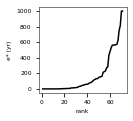

In [36]:
### Figure 6b - rank elevation critical node 

table = pd.read_csv(".\\Results\\Results_AllBarriers.csv", sep=",", header=0) 
df = table[['Barrier','Critical_exceedance']]
df.sort_values("Critical_exceedance", inplace=True)
df['Rank']= list(range(1,72))

x= df['Rank']
y= df['Critical_exceedance']

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(4*cm,4*cm))
ax.plot(x,y, '-',color="k")
  
plt.xlabel("rank")
plt.ylabel('e* (yr)')
 
plt.rcParams["font.size"]= 6

plt.savefig(".\\Figures\\Fig6b.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig6b.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/187587485.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values("Critical_elevation", inplace=True)


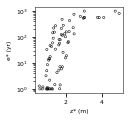

In [38]:
### Figure 6c - exceedance vs elevation critical node 

table = pd.read_csv(".\\Results\\Results_AllBarriers.csv", sep=",", header=0) 
df = table[['Barrier','Critical_exceedance','Critical_elevation']]
df.sort_values("Critical_elevation", inplace=True)

x= df['Critical_elevation']
y= df['Critical_exceedance']

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(4*cm,4*cm))
ax.scatter(x,y,marker='o', c='none', edgecolor='k', linewidth=0.5, s=5)
  
plt.ylabel("e* (yr)")
plt.xlabel('z* (m)')
ax.set_yscale('log')

plt.rcParams["font.size"]= 6

plt.savefig(".\\Figures\\Fig6c.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig6c.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 7a - GCC size classified by robustness 

table = pd.read_csv(".\\Results\\Results_AllBarriers.csv", sep=",", header=0) 
df = table[['Barrier','Robustness']]
df.sort_values("Robustness", inplace=True)
df['Rank']= list(range(1,72))

rootdir = '.\\Data\\Roads'
extensions = ('.graphml')

viridis = cm.get_cmap('viridis', 71)
viridis
colors=[]
for i in range(viridis.N):
    rgba = viridis(i)
    # rgb2hex accepts rgb or rgba
    a=cm.colors.rgb2hex(rgba)
    colors.append(a)
df['Color']=colors

# Loop through files and open barrier graphml
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            file_path = os.path.join(subdir, file)
            barrier = file.replace(".graphml","")
            G = nx.read_graphml(file_path)
            N= len(G.nodes(data=True))
            
            if N>100:
                # pull out elevation attribute
                E = nx.get_node_attributes(G,'Elevations')
                # convert str values in float to be able to sort them 
                E = dict(zip(E.keys(), [float(value) for value in E.values()]))
                # sort it based on elevation, min first
                Sorted_E = sorted(E.items(), key=lambda item: item[1])
                CCs = np.zeros([len(Sorted_E),1])
                # select first element of each tuple in the list (nodes ID):
                FT = [i[0] for i in Sorted_E]
                # select second element of each tuple in the list (elevation) and convert to float
                ST = [i[1] for i in Sorted_E]
                for i in range(len(ST)):
                    ST[i] = float(ST[i])

                # loop through all nodes
                for i in range(0, len(FT)):
                    # find the node with lowest elevation from the list using i and remove it
                    G.remove_nodes_from(FT[0:i])
                    # check giant component size
                    CCs[int(i),0]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT)           

                x_coord = 1 * np.arange(len(CCs))/len(CCs) # x axis
                plt.plot(x_coord,CCs[:,0],'-', linewidth=0.5, color=df.loc[df['Barrier'] == barrier, 'Color'].values[0], label=barrier)

cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (4*cm,4*cm) 

plt.axline((0, 1), (1, 0), linewidth=1, zorder=1, color='#999999', linestyle='--', label='1:1 line')
plt.xlabel("q")
plt.ylabel("GCC size")
plt.rcParams["font.size"]= 6 

plt.savefig(".\\Figures\\Fig7a.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig7a.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

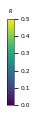

In [77]:
# Colorbar for Fig 7a #

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(0.3*cm,4*cm))
# fig.subplots_adjust(bottom=0.7, left=-0.2)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'),
             cax=ax, orientation='vertical')
ax.set_title('$\it{R}$', fontsize=5 )

plt.rcParams["font.size"]= 6

plt.savefig(".\\Figures\\Fig7a_colorbar.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig7a_colorbar.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 7b - rank robustness 

table = pd.read_csv(".\\Results\\Results_AllBarriers.csv", sep=",", header=0) 
df = table[['Barrier','Robustness']]
df.sort_values("Robustness", inplace=True)
df['Rank']= list(range(1,72))

x= df['Rank']
y= df['Robustness']

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(4*cm,4*cm))

ax.plot(x,y, '-',color="k")
plt.xlabel("rank")
plt.ylabel("$R$")
plt.rcParams["font.size"]= 6


plt.savefig(".\\Figures\\Fig7b.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig7b.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 7c - Random vs elevation removal 

# Elevation-based node removal
G = nx.read_graphml('.\\Data\\Roads\\FL28.graphml')
E = nx.get_node_attributes(G,'Elevations')
E = dict(zip(E.keys(), [float(value) for value in E.values()]))
Sorted_E = sorted(E.items(), key=lambda item: item[1])
CCs = np.zeros([len(Sorted_E),2])
FT = [i[0] for i in Sorted_E]
ST = [i[1] for i in Sorted_E]
for i in range(len(ST)):
    ST[i] = float(ST[i])
for i in range(0, len(FT)):
    G.remove_nodes_from(FT[0:i])
    CCs[int(i),0]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT)

x_coord = 1 * np.arange(len(CCs))/len(CCs) # x axis
plt.plot(x_coord,CCs[:,0],'-k', linewidth=1, zorder=5, label="elevation removal")

# Random node removal 1
G = nx.read_graphml('.\\Data\\Roads\\FL28.graphml')
FT_rdm= random.sample(FT, len(FT))
for i in range(0, len(FT_rdm)):
    G.remove_nodes_from(FT_rdm[0:i])
    CCs[int(i),1]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT_rdm)
    
plt.plot(x_coord,CCs[:,1],'-', color= '#808080', linewidth=0.5, label="random removal")
      
# Random node removal 2
G = nx.read_graphml('.\\Data\\Roads\\FL28.graphml')
FT_rdm= random.sample(FT, len(FT))
# Loop through all nodes
for i in range(0, len(FT_rdm)):
    G.remove_nodes_from(FT_rdm[0:i])
    CCs[int(i),1]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT_rdm)

plt.plot(x_coord,CCs[:,1], '-', color= '#808080', linewidth=0.5)

# Random node removal 3
G = nx.read_graphml('.\\Data\\Roads\\FL28.graphml')
FT_rdm= random.sample(FT, len(FT))
for i in range(0, len(FT_rdm)):
    G.remove_nodes_from(FT_rdm[0:i])
    CCs[int(i),1]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT_rdm)

plt.plot(x_coord,CCs[:,1],'-', color= '#808080', linewidth=0.5)

# Random node removal 4
G = nx.read_graphml('.\\Data\\Roads\\FL28.graphml')
FT_rdm= random.sample(FT, len(FT))
# Loop through all nodes
for i in range(0, len(FT_rdm)):
    G.remove_nodes_from(FT_rdm[0:i])
    CCs[int(i),1]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT_rdm)
    
plt.plot(x_coord,CCs[:,1], '-', color= '#808080', linewidth=0.5)

plt.axline((0, 1), (1, 0), linewidth=1, color='#999999', linestyle='--')


cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (4*cm,4*cm) 
plt.rcParams["font.size"]= 6   

plt.xlabel("q")
plt.ylabel("GCC size")
plt.legend(frameon=False, fontsize=4)

plt.savefig(".\\Figures\\Fig7c.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig7c.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure 7d - Random vs elevation removal 

# Elevation-based node removal
G = nx.read_graphml('.\\Data\\Roads\\SC1.graphml')
E = nx.get_node_attributes(G,'Elevations')
E = dict(zip(E.keys(), [float(value) for value in E.values()]))
Sorted_E = sorted(E.items(), key=lambda item: item[1])
CCs = np.zeros([len(Sorted_E),2])
FT = [i[0] for i in Sorted_E]
ST = [i[1] for i in Sorted_E]
for i in range(len(ST)):
    ST[i] = float(ST[i])
for i in range(0, len(FT)):
    G.remove_nodes_from(FT[0:i])
    CCs[int(i),0]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT)

x_coord = 1 * np.arange(len(CCs))/len(CCs) # x axis
plt.plot(x_coord,CCs[:,0],'-k', linewidth=1, zorder=5, label="elevation removal")

# Random node removal 1
G = nx.read_graphml('.\\Data\\Roads\\SC1.graphml')
FT_rdm= random.sample(FT, len(FT))
for i in range(0, len(FT_rdm)):
    G.remove_nodes_from(FT_rdm[0:i])
    CCs[int(i),1]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT_rdm)
    
plt.plot(x_coord,CCs[:,1],'-', color= '#808080', linewidth=0.5, label="random removal")
      
# Random node removal 2
G = nx.read_graphml('.\\Data\\Roads\\SC1.graphml')
FT_rdm= random.sample(FT, len(FT))
# Loop through all nodes
for i in range(0, len(FT_rdm)):
    G.remove_nodes_from(FT_rdm[0:i])
    CCs[int(i),1]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT_rdm)

plt.plot(x_coord,CCs[:,1], '-', color= '#808080', linewidth=0.5)

# Random node removal 3
G = nx.read_graphml('.\\Data\\Roads\\SC1.graphml')
FT_rdm= random.sample(FT, len(FT))
for i in range(0, len(FT_rdm)):
    G.remove_nodes_from(FT_rdm[0:i])
    CCs[int(i),1]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT_rdm)

plt.plot(x_coord,CCs[:,1],'-', color= '#808080', linewidth=0.5)

# Random node removal 4
G = nx.read_graphml('.\\Data\\Roads\\SC1.graphml')
FT_rdm= random.sample(FT, len(FT))
# Loop through all nodes
for i in range(0, len(FT_rdm)):
    G.remove_nodes_from(FT_rdm[0:i])
    CCs[int(i),1]= largest_cc = len(max(nx.weakly_connected_components(G), key=len))/len(FT_rdm)
    
plt.plot(x_coord,CCs[:,1], '-', color= '#808080', linewidth=0.5)

plt.axline((0, 1), (1, 0), linewidth=1, color='#999999', linestyle='--')


cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (4*cm,4*cm) 
plt.rcParams["font.size"]= 6   

plt.xlabel("q")
plt.ylabel("GCC size")
plt.legend(frameon=False, fontsize=4)

plt.savefig(".\\Figures\\Fig7d.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig7d.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)


In [ ]:
### Figure 8a - scatter robustness - elevation 

table = pd.read_csv(".\\Results\\Results_AllBarriers.csv", sep=",", header=0) 

x=table['Critical_threshold']
y=table['Robustness']
plt.scatter(x,y,marker='o', c="none", edgecolor='k', linewidth=0.5, s=5)
cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (4*cm,4*cm) 

plt.xlabel("$q_c$")
plt.ylabel("R")
 
plt.rcParams["font.size"]= 6
plt.savefig(".\\Figures\\Fig8a.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig8a.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

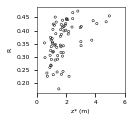

In [79]:
### Figure 8b - scatter robustness - elevation 

table = pd.read_csv(".\\Results\Results_AllBarriers.csv", sep=",", header=0) 

x=table['Critical_elevation']
y=table['Robustness']
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(4*cm,4*cm))
ax.scatter(x,y,marker='o', c='none', edgecolor='k', linewidth=0.5, s=5)

plt.xlabel("z* (m)")

plt.ylabel("R")
 
plt.rcParams["font.size"]= 6

ax.set_xticks(ax.get_xticks()[::1])

plt.savefig(".\\Figures\\Fig8b.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig8b.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

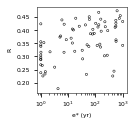

In [80]:
### Figure 8c - scatter robustness - elevation 

table = pd.read_csv(".\\Results\Results_AllBarriers.csv", sep=",", header=0) 

x=table['Critical_exceedance']
y=table['Robustness']

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(4.1*cm,4*cm))
ax.scatter(x,y,marker='o', c='none', edgecolor='k', linewidth=0.5, s=5)
  
plt.ylabel("R")
plt.xlabel('e* (yr)')
ax.set_xscale('log')

plt.rcParams["font.size"]= 6
plt.savefig("C:\\Users\\Sofia\\Dropbox\\NETWORKS\\All_barriers\\Figures_3\\Fig8\\Fig8c.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig("C:\\Users\\Sofia\\Dropbox\\NETWORKS\\All_barriers\\Figures_3\\Fig8\\Fig8c.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig8c.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig8c.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/1533669699.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_values("Critical_elevation", inplace=True)
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/1533669699.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Rank']= list(range(1,72))
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/1533669699.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

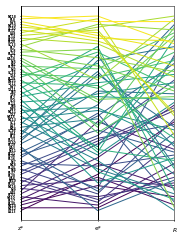

In [31]:
### Figure 9 - Parallel plot critical elevation, critical exceedance, robustness 

table = pd.read_csv(".\\Results\Results_AllBarriers.csv", sep=",", header=0) 

df2 = table[['Barrier','Critical_elevation']]
df3= table[['Barrier','Critical_exceedance']]
df4 = table[['Barrier','Robustness']]
df2.sort_values("Critical_elevation", inplace=True)
df2['Rank']= list(range(1,72))
df3.sort_values("Critical_exceedance", inplace=True)
df3['Rank']= list(range(1,72))
df4.sort_values("Robustness", inplace=True)
df4['Rank']= list(range(1,72))

df= table[['Barrier']]
df= pd.merge(df,df2[['Barrier','Rank']],on='Barrier', how='left')
df= pd.merge(df,df3[['Barrier','Rank']],on='Barrier', how='left')
df= pd.merge(df,df4[['Barrier','Rank']],on='Barrier', how='left')
df.columns = ['Barrier','z*', 'e*', '$R$']
df.sort_values("z*", inplace=True)


viridis = cm.get_cmap('viridis', 71)
viridis
colours=[]
for i in range(viridis.N):
    rgba = viridis(i)
    # rgb2hex accepts rgb or rgba
    a=cm.colors.rgb2hex(rgba)
    colours.append(a)


fig=pd.plotting.parallel_coordinates(df, 'Barrier', color=colours, linewidth=1)
fig.set_yticklabels(df.Barrier)
plt.yticks(np.arange(1, 72, 1))
fig.get_legend().remove()

cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (7*cm,10*cm) 
plt.rcParams["font.size"]= 6
plt.yticks(fontsize=3, fontweight='bold')

# Turns off grid on the left Axis.
fig.grid(False)

fig.tick_params(axis=u'both', which=u'both',length=1)

from pylab import * 
rc('axes', linewidth=0.5)

plt.savefig(".\\Figures\\Fig9.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig9.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
# Colorbar for Fig 9 #

viridis = cm.get_cmap('viridis', 71)
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(0.3*cm,10*cm))

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0.5, vmax=4.96)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=viridis),
             cax=ax, orientation='vertical')
h = plt.ylabel('       z*', fontsize=8)
h.set_rotation(0)
plt.rcParams["font.size"]= 6

plt.savefig(".\\Figures\\Fig9_colorbar.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Fig9_colorbar.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

In [ ]:
### Figure for supplement 
 
table = pd.read_csv(".\\Results\Results_AllBarriers.csv", sep=",", header=0) 

df2 = table[['Barrier','Critical_elevation']]
df3= table[['Barrier','Critical_exceedance']]
df4 = table[['Barrier','Robustness']]
df2.sort_values("Critical_elevation", inplace=True)
df2['Rank']= list(range(1,72))
df3.sort_values("Critical_exceedance", inplace=True)
df3['Rank']= list(range(1,72))
df4.sort_values("Robustness", inplace=True)
df4['Rank']= list(range(1,72))
df= table[['Barrier']]
df= pd.merge(df,df2[['Barrier','Rank']],on='Barrier', how='left')
df= pd.merge(df,df3[['Barrier','Rank']],on='Barrier', how='left')
df= pd.merge(df,df4[['Barrier','Rank']],on='Barrier', how='left')
df.columns = ['Barrier','z*', 'e*', 'r']

x= df["z*"]
y= df["e*"]
s= plt.scatter(x, y, marker= "o", c="#00A9E6",  alpha=0.5, linewidth=0.5, s=7)
plt.axline((0, 0), (71, 71), linewidth=1, color='black', linestyle=':', label="1:1 line")

cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (5*cm,5*cm) 

plt.xlabel("z* rank")
plt.ylabel('e* rank')
 
plt.rcParams["font.size"]= 6
cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (5*cm,5*cm) 

annotations= df['Barrier']
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]), fontsize=1.5, weight='bold')

plt.savefig(".\\Figures\\Supplement1.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Supplement1.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/2718041298.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_values("Critical_elevation", inplace=True)
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/2718041298.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Rank']= list(range(1,72))
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/2718041298.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

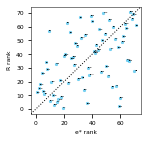

In [34]:
### Figure for supplement 
 
table = pd.read_csv(".\\Results\Results_AllBarriers.csv", sep=",", header=0) 

df2 = table[['Barrier','Critical_elevation']]
df3= table[['Barrier','Critical_exceedance']]
df4 = table[['Barrier','Robustness']]
df2.sort_values("Critical_elevation", inplace=True)
df2['Rank']= list(range(1,72))
df3.sort_values("Critical_exceedance", inplace=True)
df3['Rank']= list(range(1,72))
df4.sort_values("Robustness", inplace=True)
df4['Rank']= list(range(1,72))
df= table[['Barrier']]
df= pd.merge(df,df2[['Barrier','Rank']],on='Barrier', how='left')
df= pd.merge(df,df3[['Barrier','Rank']],on='Barrier', how='left')
df= pd.merge(df,df4[['Barrier','Rank']],on='Barrier', how='left')
df.columns = ['Barrier','z*', 'e*', 'r']

x= df["e*"]
y= df["r"]
s= plt.scatter(x, y, marker= "o", c="#00A9E6",  alpha=0.5, linewidth=0.5, s=7)
plt.axline((0, 0), (71, 71), linewidth=1, color='black', linestyle=':', label="1:1 line")

cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (5*cm,5*cm) 

plt.xlabel("e* rank")
plt.ylabel('R rank')

annotations= df['Barrier']
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]), fontsize=1.5, weight='bold')

    
plt.rcParams["font.size"]= 6
cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (5*cm,5*cm) 

plt.savefig(".\\Figures\\Supplement2.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Supplement2.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)

C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/3027077249.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_values("Critical_elevation", inplace=True)
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/3027077249.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Rank']= list(range(1,72))
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9568/3027077249.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

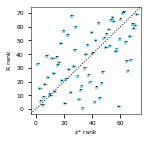

In [35]:
### Figure for supplement 

table = pd.read_csv(".\\Results\Results_AllBarriers.csv", sep=",", header=0) 

df2 = table[['Barrier','Critical_elevation']]
df3= table[['Barrier','Critical_exceedance']]
df4 = table[['Barrier','Robustness']]
df2.sort_values("Critical_elevation", inplace=True)
df2['Rank']= list(range(1,72))
df3.sort_values("Critical_exceedance", inplace=True)
df3['Rank']= list(range(1,72))
df4.sort_values("Robustness", inplace=True)
df4['Rank']= list(range(1,72))
df= table[['Barrier']]
df= pd.merge(df,df2[['Barrier','Rank']],on='Barrier', how='left')
df= pd.merge(df,df3[['Barrier','Rank']],on='Barrier', how='left')
df= pd.merge(df,df4[['Barrier','Rank']],on='Barrier', how='left')
df.columns = ['Barrier','z*', 'e*', 'r']

x= df["z*"]
y= df["r"]

s= plt.scatter(x, y, marker= "o", c="#00A9E6",  alpha=0.5, linewidth=0.5, s=7)
plt.axline((0, 0), (71, 71), linewidth=1, color='black', linestyle=':', label="1:1 line")

cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (5*cm,5*cm) 

plt.xlabel("z* rank")
plt.ylabel('R rank')

annotations= df['Barrier']
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]), fontsize=1.5, weight='bold')

plt.rcParams["font.size"]= 6
cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (5*cm,5*cm) 

plt.savefig(".\\Figures\\Supplement3.png", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)
plt.savefig(".\\Figures\\Supplement3.eps", dpi=500, facecolor='w',  bbox_inches='tight',pad_inches = 0)